<a href="https://colab.research.google.com/github/kryogenica/Image-compression-using-Matrix-Product-States/blob/master/Image_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Product States to lossly compress images

This notebook is based on the work of the paper titled "[Tensor Networks for Image Compression](http://diposit.ub.edu/dspace/bitstream/2445/96365/1/TFG_Fis_Trujillo_Boque_Alex.pdf)" by Alex Trujillo Boque.

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import math
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


Images to be used will be from the Fashion-MNIST data set.


In [0]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Preprocess the data

The data must be preprocessed before implementing it through the Matrix Product State (MPS) tensor network. If you inspect the first image in the training set (below), its pixel values fall in the range of 0 to 255:

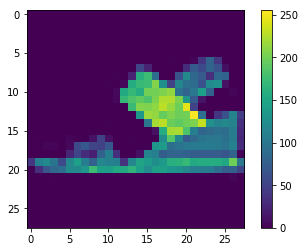

In [16]:
image = train_images[217]
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)
plt.show()

We scale these values to range from 0 to 1 before trying to compress it through the MPS network. For this, we divide the values by 255.

In [0]:
train_images = train_images / 255.0

test_images = test_images / 255.0

As you can see in the image below its pixel values range from 0 to 1.

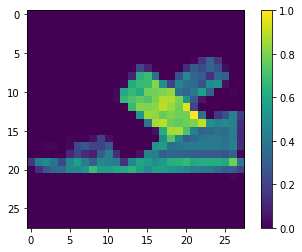

In [18]:
image = train_images[217]
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)
plt.show()

Before proceeding a small patch of the above image will be extracted. This will be used as a smaller image as to better explain the following content. A requirement to compress an image through the MPS algorithim that we will see ahead is that it should be a square image of sides equal to L.

With ***L*** being a solution to

\begin{equation}
\ n = log_{p} (L^2), \hspace{0.3cm} p=m^2
\end{equation}

under the condition that ***n*** needs to be an integer. The meaning of ***n*** and ***p*** will be explained below.

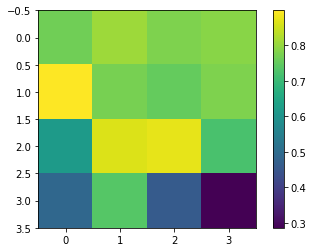

In [19]:
image = train_images[217][13:17,17:21]
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)
plt.show()

In the image above ***L*** clearly equals 4 and ***p*** is equivalent to 2^2.

***p*** is the number of pixels in each square sub-block.

Using the schematic below to label the pixels in the image above and separate it into sub-blocks one sees that ***p*** is 2^2 for this case.  Additionally all pixels have two coordinates assigned to them. This is equivalent to ***n*** in the equation of the text cell above if we where to assign ***L*** and ***p*** the values mentioned in this text cell.


![SubBlockSystem](https://drive.google.com/uc?export=view&id=1JEYmaje0RSEBdKyDnHELD5TU2eYsi0wW)

Using the equation above and with predetermined p value do we calculate the number of croas graining levels in the image.

In [20]:
m = 2
p = m*m
L = image.shape[0]
levels = int(math.log((L*L),p))
print (levels)

2


There is a function within TensorFlow that will allow us to "chop up" the image into sub-blocks and by the same fashion as the schematic above.
The function is ***tf.extract_image_patches***. There is one problem with using it, our "image" is a rank 2 tensor (numpy.ndarray) and this function takes in rank 4 tensors.


So we must convert the image into a rank 4 tensor.



In [0]:
sess = tf.Session()
with sess.as_default():
  tensor = tf.constant(image)
  t = tf.expand_dims(tensor, 0)
  del tensor
  tensor = tf.expand_dims(t, -1)
  del t
  chopped_image = tf.extract_image_patches(images=tensor, ksizes=[1, 2, 2, 1], strides=[1, 2, 2, 1], rates=[1, 1, 1, 1], padding='VALID').eval()
  del tensor
#The reasons that the function takes a 4 rank tensor are:  
#First dimension is the reference to the image itself (this function can take batches of images).
#The second and third dimension is the location of each pixel.
#The fourth dimension is the value of each pixel. In our case its just a grey scale value.

There is a benifit of using the tensorflow funtion above and it is that our pixels have been given orderly organization. We can explot this further on.

Next lets use our latest result to create a vector to use under a outter product to generate the density matrix of this image.

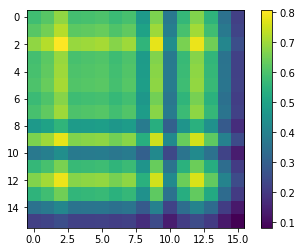

In [22]:
C_vectorized = np.reshape(np.squeeze(chopped_image),L*L)
density_matrix = np.outer(C_vectorized,C_vectorized)
#density_matrix = np.kron(C,C)
plt.figure()
plt.imshow(density_matrix)
plt.colorbar()
plt.grid(False)
plt.show()

In [39]:
organization = np.ndarray(shape=((L*L),levels))
z = 0
for k in range(0,L*L):
  organization[k,0] = z
  z += 1
  if z==p:
    z = 0

location = organization[:,0].copy()

for k in range(1,levels):
  u = 0
  u_counter = 1
  z = 0
  z_counter = 0
  y = 0
  level_counter = int(math.pow(m,k-1))
  level_above = int(math.pow(m,k))
  l_c = 0
  for i in location:
    organization[y,k] = z
    y += 1
    if i==(p-1):
      l_c += 1
      if l_c==level_counter:
        l_c = 0
        z += 1
        z_counter += 1
        if z_counter==level_above:
          print ('hello')
          z_counter = 0
          z =  u*m
          u_counter += 1
          if u_counter==int(L/level_above):
            u += 1
            z = u*m
            if u==m:
              u=0

hello
hello


In [40]:
print (location)
print (organization)

[0. 1. 2. 3. 0. 1. 2. 3. 0. 1. 2. 3. 0. 1. 2. 3.]
[[0. 0.]
 [1. 0.]
 [2. 0.]
 [3. 0.]
 [0. 1.]
 [1. 1.]
 [2. 1.]
 [3. 1.]
 [0. 2.]
 [1. 2.]
 [2. 2.]
 [3. 2.]
 [0. 3.]
 [1. 3.]
 [2. 3.]
 [3. 3.]]
